In [1]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter

plt.matplotlib.style.use('default')

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.1.5


In [2]:
# load simulated rainbow:
# r = Rainbow("test/b_withtransit_dw01.rainbow.npy")
# load Eureka! rainbow:
r_eureka = Rainbow("test/ERS_eureka/S3_nircam_wfss_template_ap8_bg16_Table_Save.txt")
# load jwst rainbow:
r_jwst = Rainbow("test/ERS_jwst/*x1dints.fits")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


In [ ]:
binwave = 0.1
bintime = 5./60
r = r_eureka.bin(dw=binwave * u.micron, dt=bintime * u.hour)

# Create Synthetic Rainbow with Transit + Polynomial

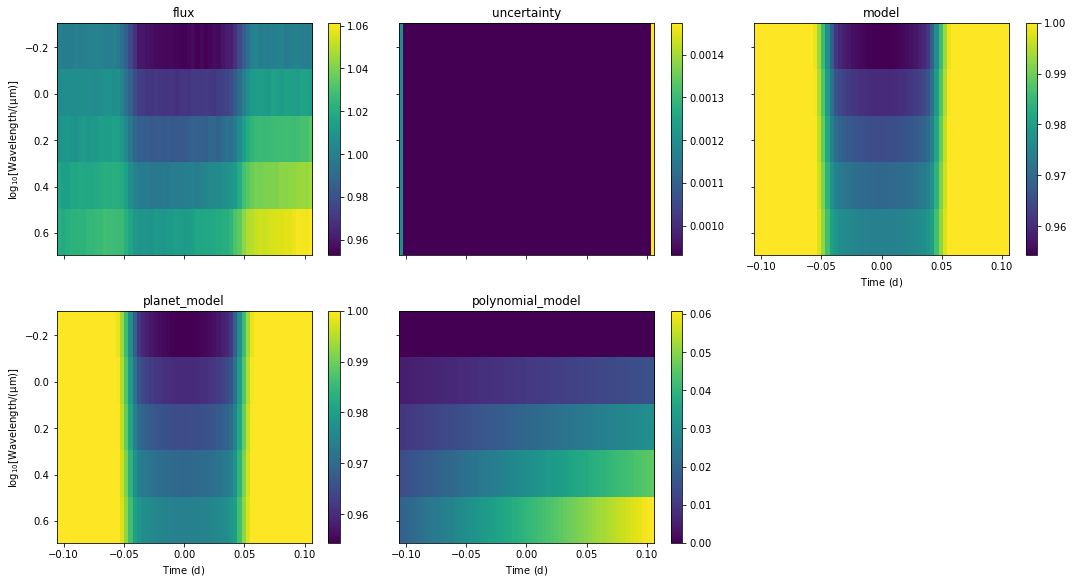

In [2]:
# create polynomial + transit rainbow:

r1 = SimulatedRainbow(signal_to_noise=100, dt=1 * u.minute, R=50)
r1 = r1.bin(nwavelengths=int(r1.nwave/5), dt=5 * u.minute)
poly=[]

# create wavelength-dep linear model:
for i in range(r1.nwave):
#     (0.5*i*(r1.time.to_value())**2) +
    poly.append((0.05*i*r1.time.to_value()) + (0.01*i))
r1.flux = r1.flux + poly

# add transit:
r = r1.inject_transit(
        planet_radius=np.linspace(0.2, 0.15, r1.nwave))
    
r.fluxlike['polynomial_model'] = np.array(poly)
r.imshow_quantities();

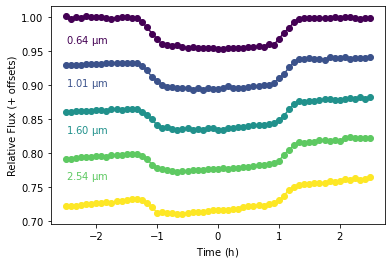

In [3]:
# plot 2d Lightcurves:
r.plot()

## White light curve


🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars

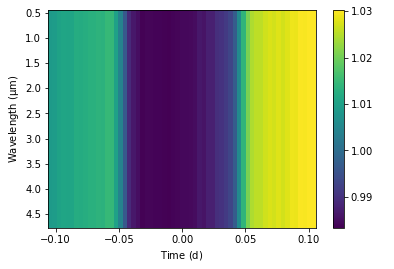

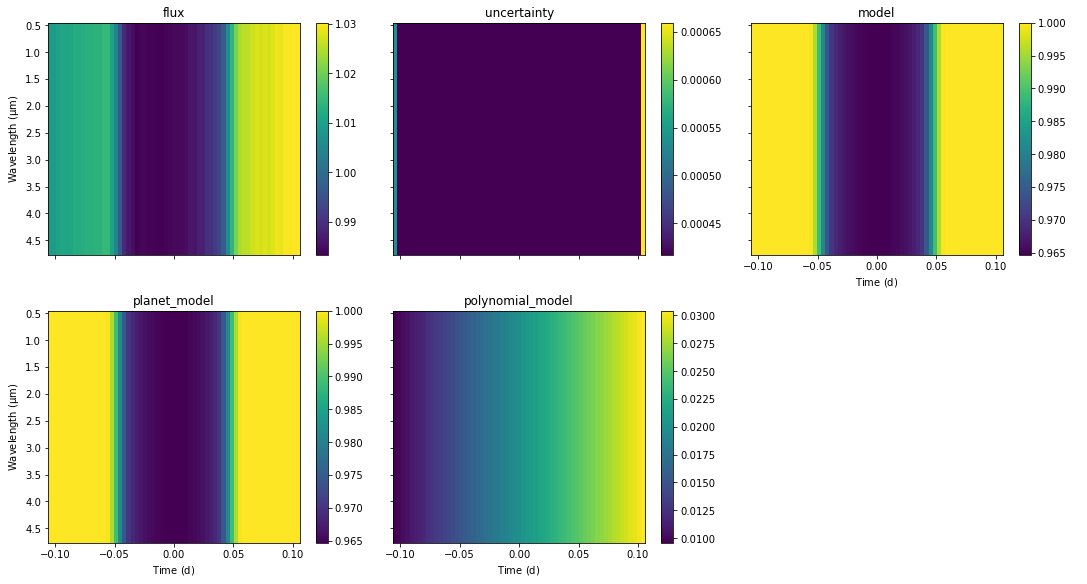

In [4]:
wa = r.bin(nwavelengths=r.nwave)
wa.imshow()
wa.imshow_quantities()

# Polynomial Model

In [4]:
# set up polynomial model:
b = PolynomialModel()
b.initialize_empty_model()
b.setup_parameters(p=WavelikeFitted(Uniform,testval=[0,0.1],upper=[0.1,0.2],lower=[-0.1,-0.2],shape=2))
b.summarize_parameters()
b.attach_data(r)
# if I setup_lightcurves for b before t it doesn't work!
b.setup_lightcurves()
# b.setup_likelihood()

p =
  <🧮 WavelikeFitted Uniform(testval=[0, 0.1], upper=[0.1, 0.2], lower=[-0.1, -0.2], shape=2, name='p') for each wavelength 🧮>



# Transit Model

In [3]:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = Fitted(Uniform, lower=0.95,upper=1.05)
#                     baseline=b
                )

t.summarize_parameters()

stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_radius') 🧮>

stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_mass') 🧮>

radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='radius_ratio') for each wavelength 🧮>

period =
  <🧮 Fixed | 1 🧮>

epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='epoch') 🧮>

baseline =
  <🧮 Fitted Uniform(lower=0.95, upper=1.05, name='baseline') 🧮>

impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='impact_parameter') 🧮>

limb_darkening =
  <🧮 Fitted QuadLimbDark(testval=[0.05, 0.35], name='limb_darkening') 🧮>



In [5]:
t.attach_data(r)
t.choose_optimization_method("separate")
t.optimization

'separate'

In [6]:
t.setup_lightcurves()
t.setup_likelihood()

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 55480.21it/s]



🌈 Warning: invalid value encountered in log

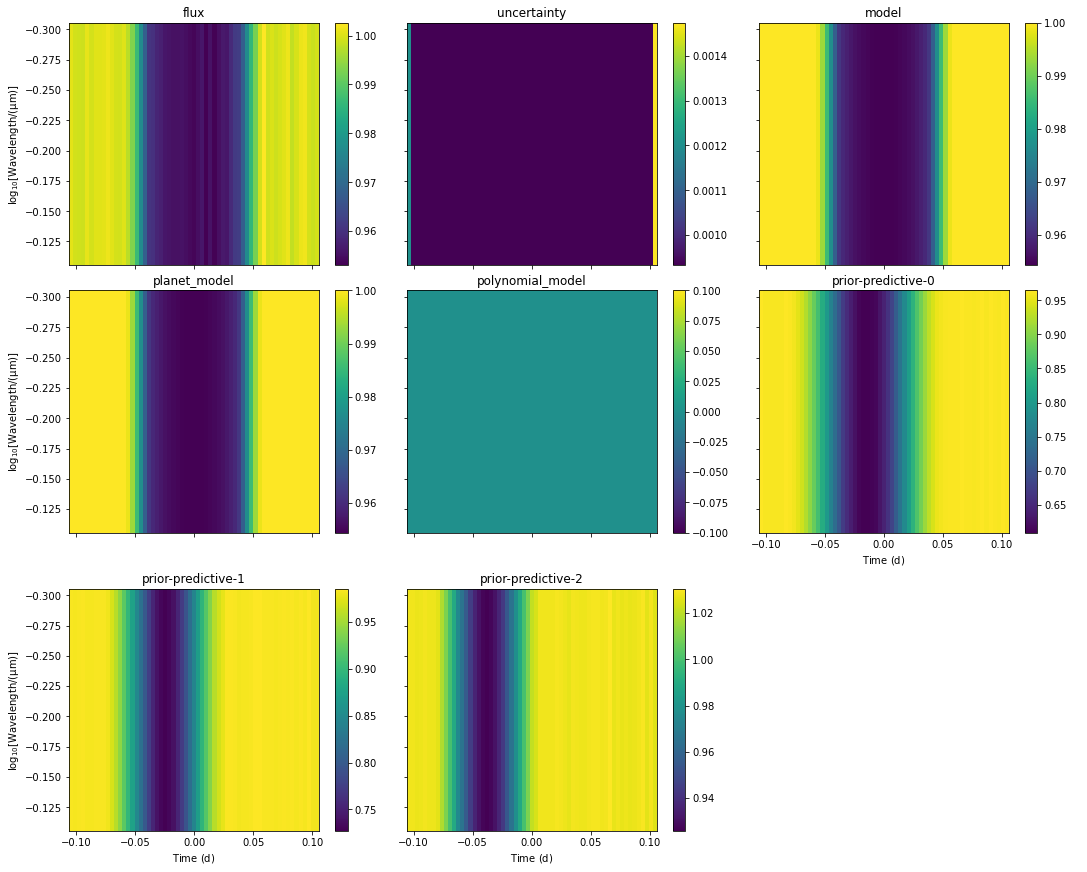

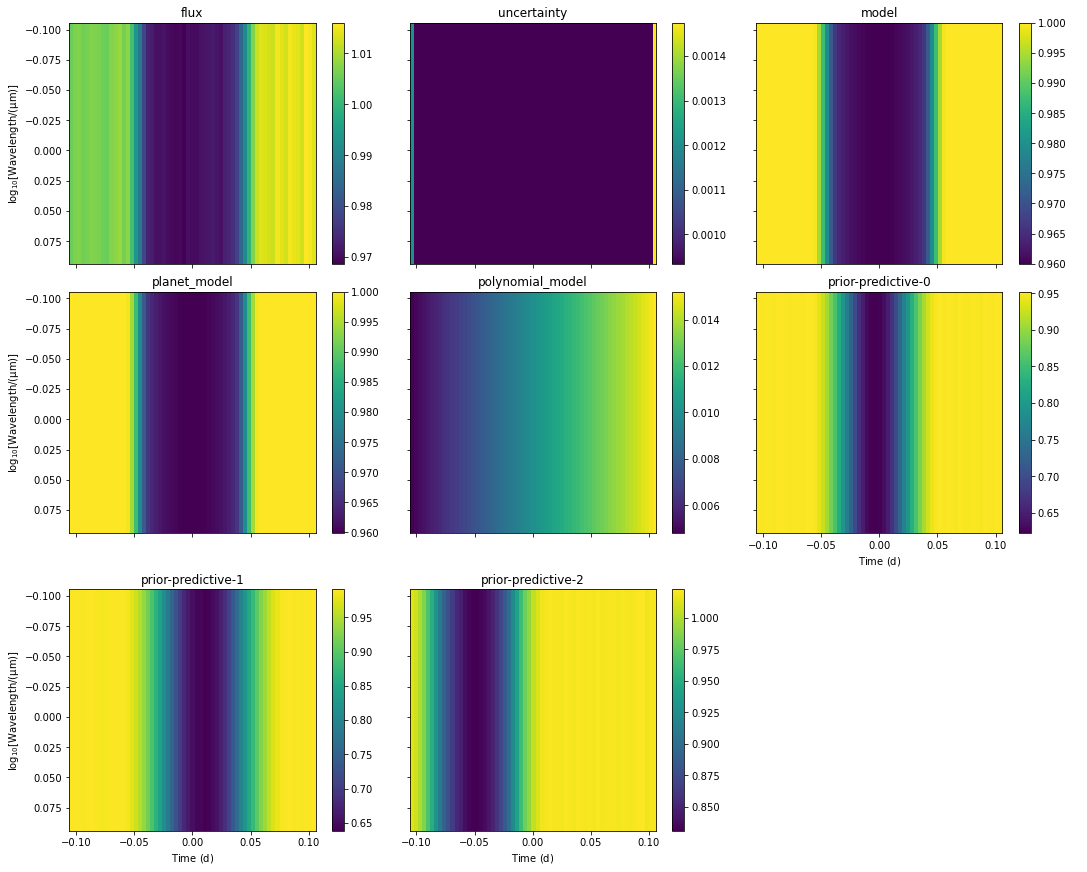

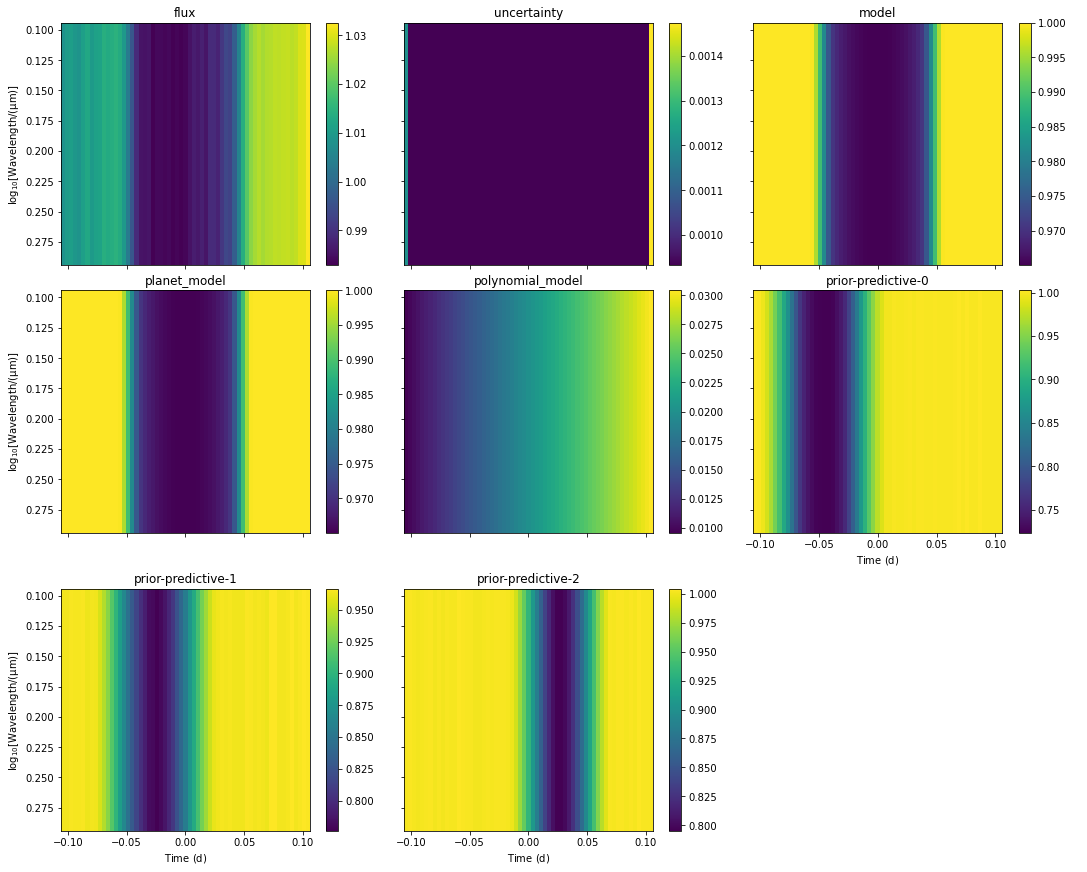

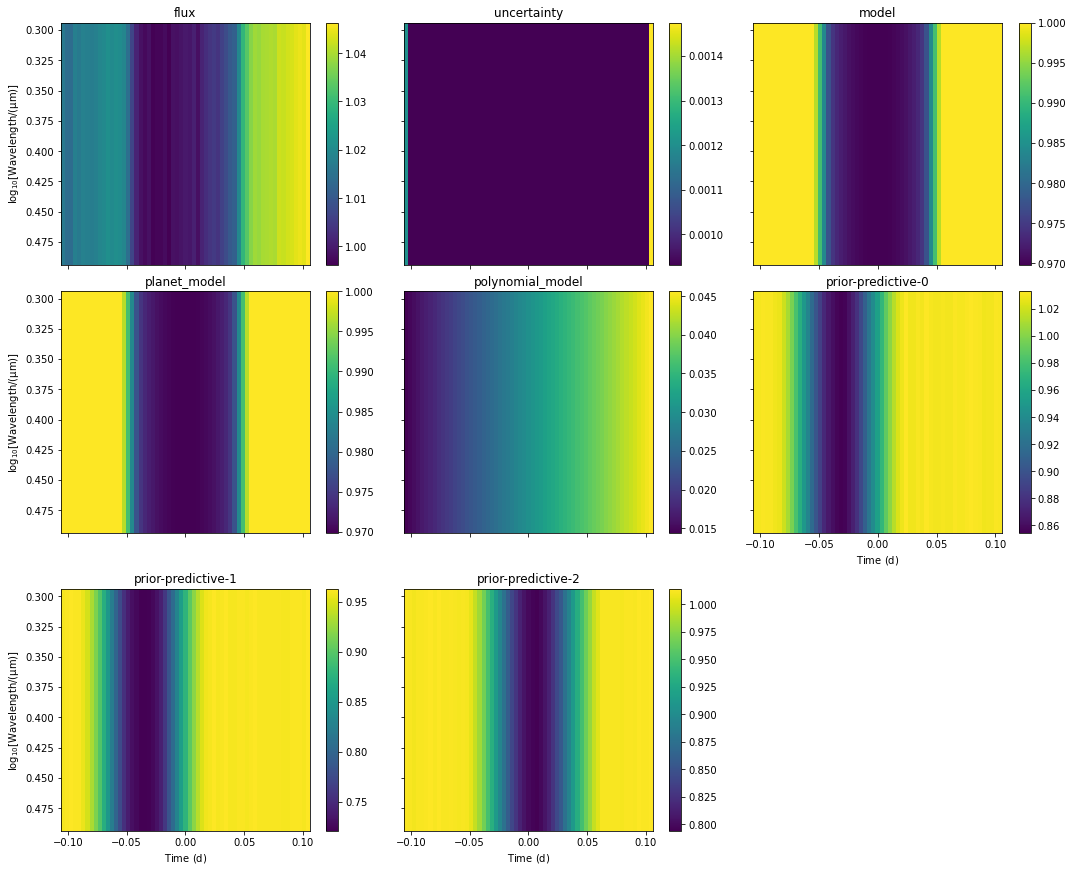

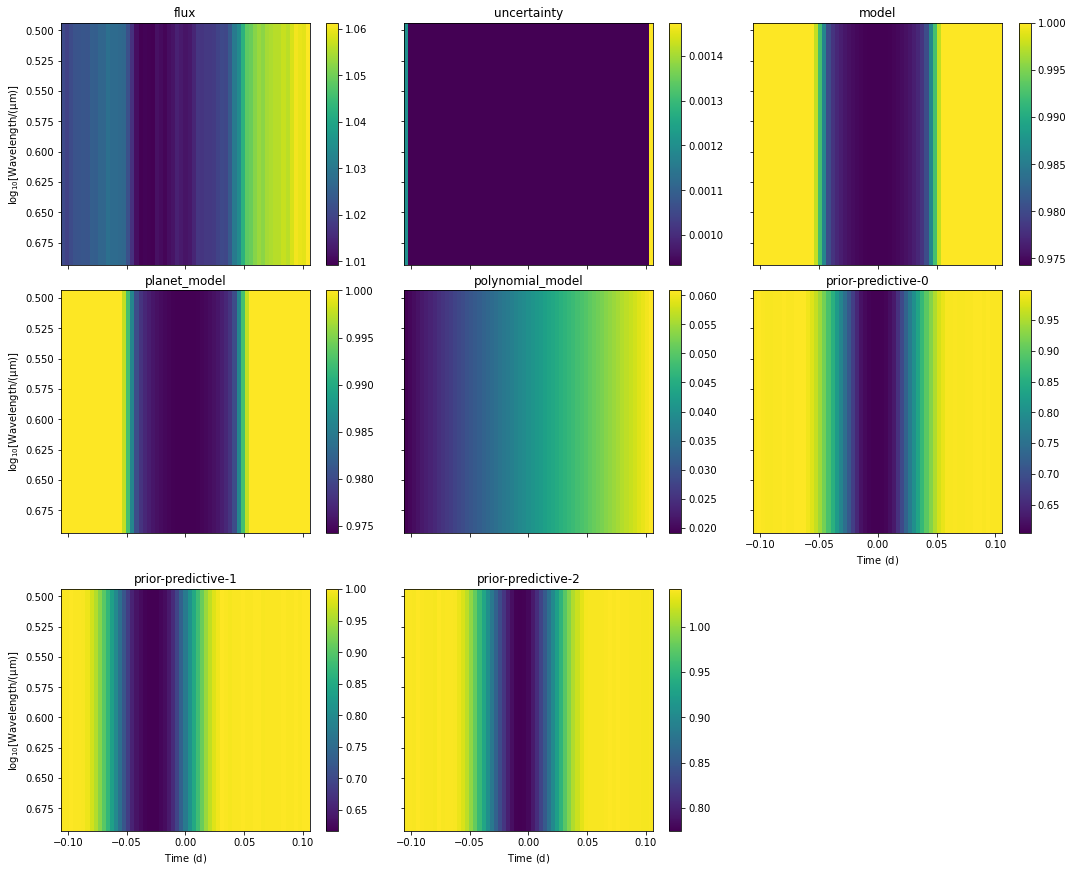

In [7]:
t.plot_priors()

In [8]:
t.sample()
t.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w0, radius_ratio_w0, limb_darkening_w0, stellar_mass_w0, stellar_radius_w0, impact_parameter_w0, epoch_w0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7994265367192, but should be close to 0.9. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w1, radius_ratio_w1, limb_darkening_w1, stellar_mass_w1, stellar_rad

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w2, radius_ratio_w2, limb_darkening_w2, stellar_mass_w2, stellar_radius_w2, impact_parameter_w2, epoch_w2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9666010157911308, but should be close to 0.9. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w3, radius_ratio_w3, limb_darkening_w3, stellar_mass_w3, stellar_radius_w3, impact_parameter_w3, epoch_w3]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w4, radius_ratio_w4, limb_darkening_w4, stellar_mass_w4, stellar_radius_w4, impact_parameter_w4, epoch_w4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.



🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

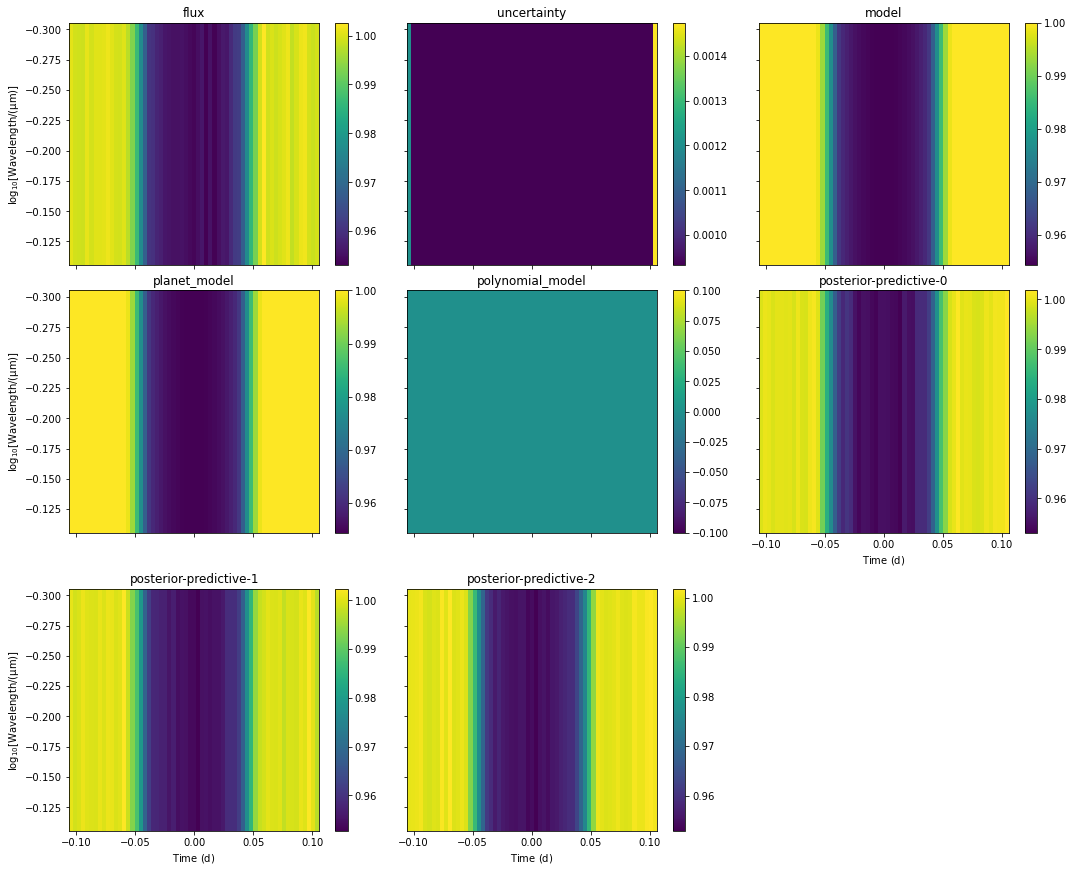

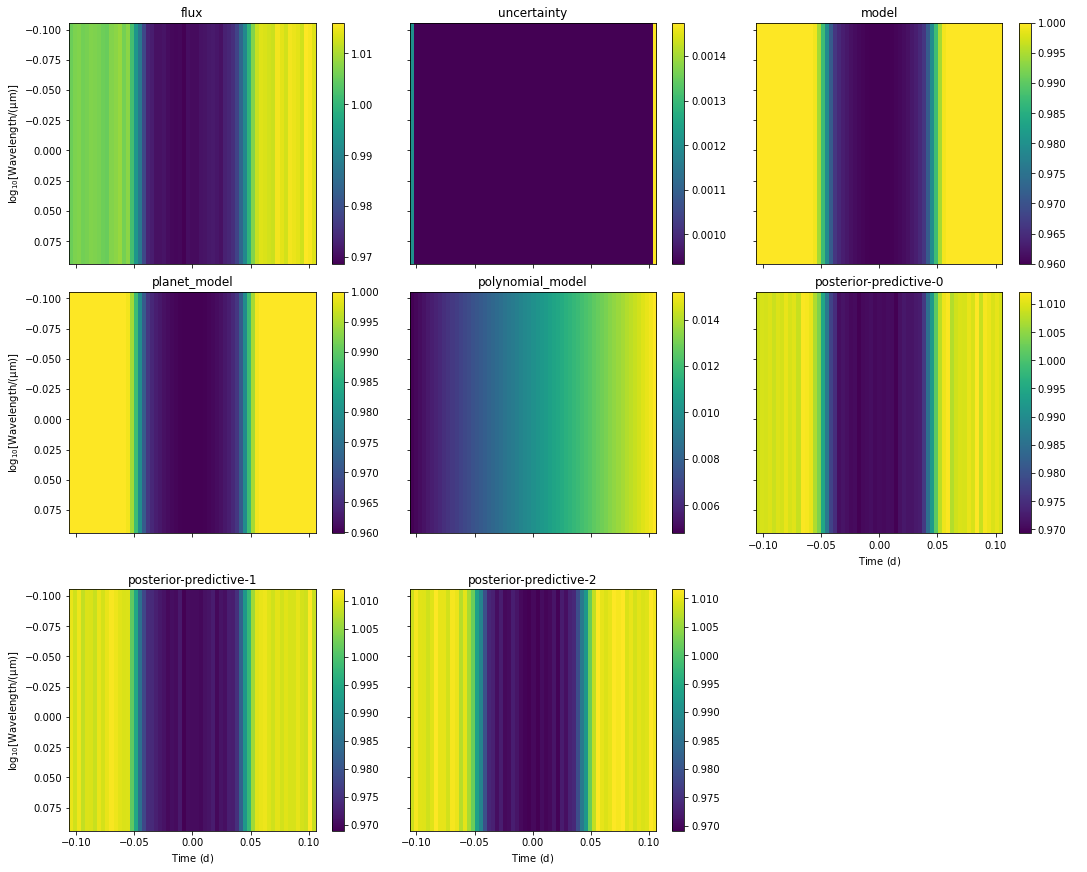

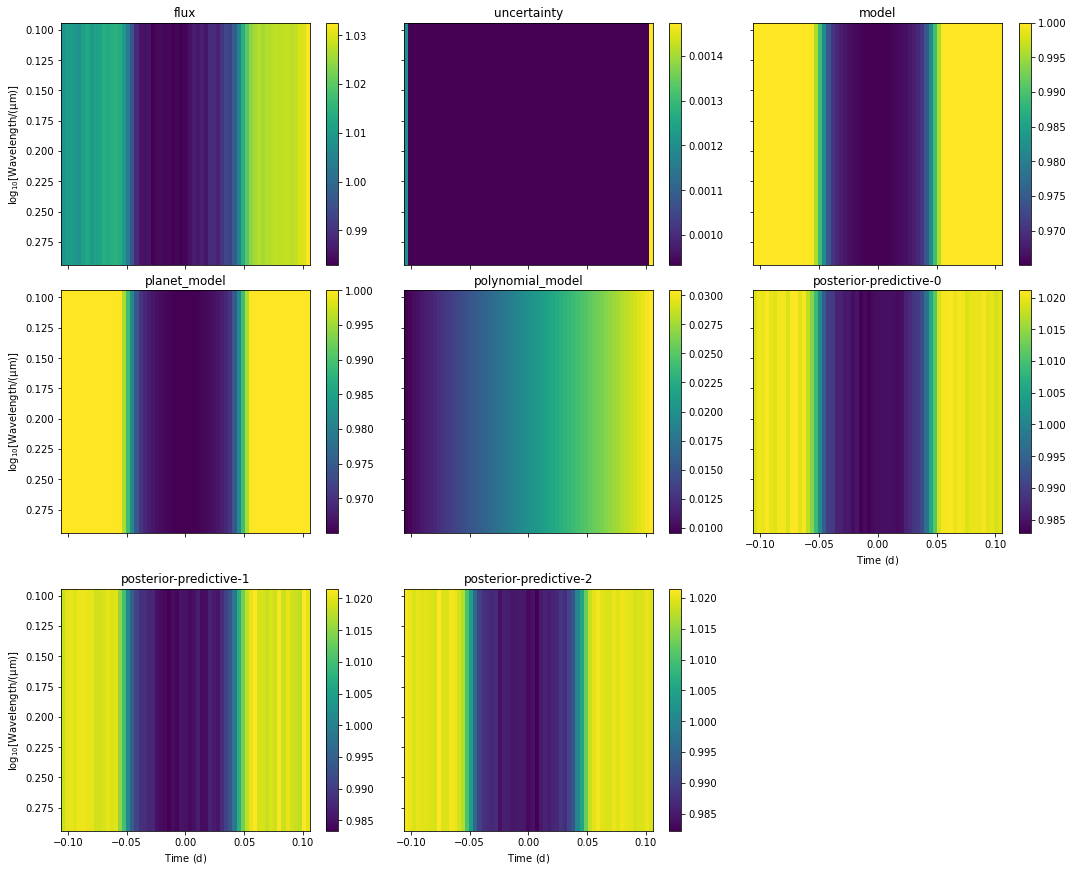

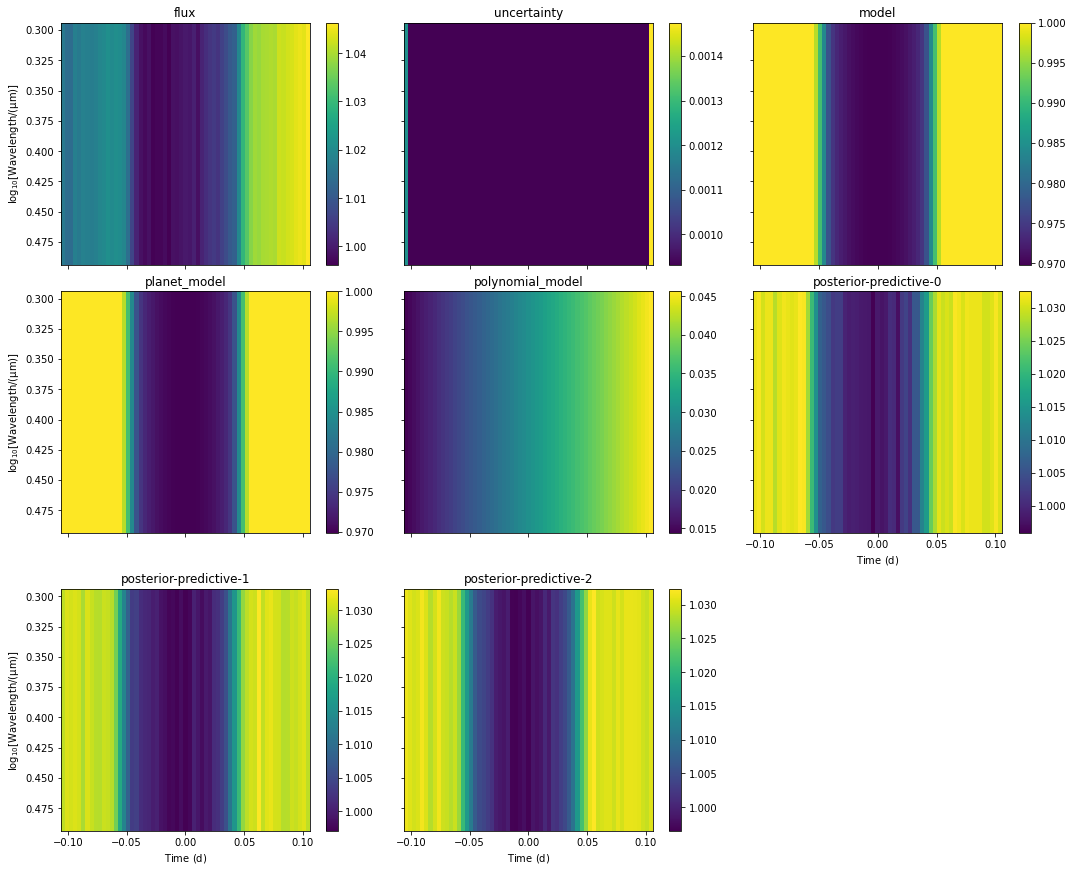

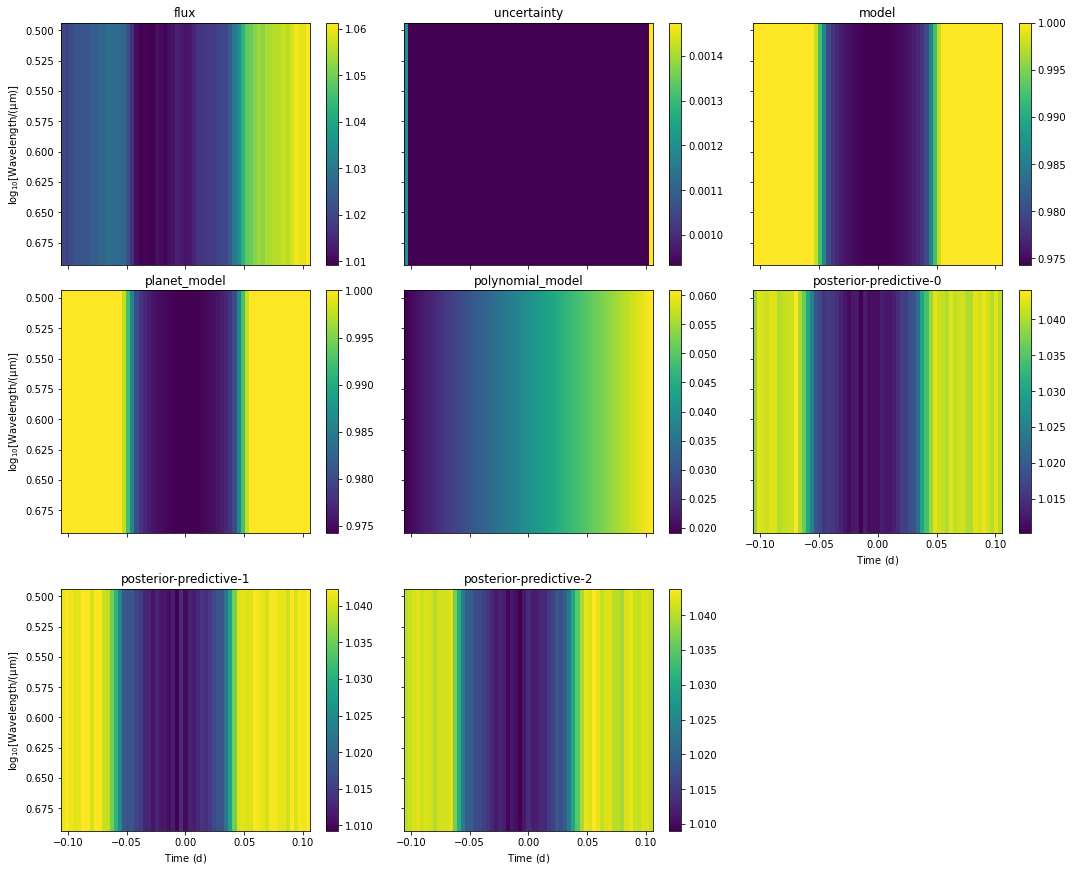

In [9]:
t.plot_posteriors()

# Combined Model!

In [5]:
## combine the models!
cm = CombinedModel()
cm.initialize_empty_model()
cm.attach_models({'transit':t,'polynomial':b})
cm.attach_data(r)
cm.choose_optimization_method("separate")
cm.setup_lightcurves()
cm.setup_likelihood()
print(cm.pymc3_models)
print(cm.pymc3_model)

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 39053.11it/s]


{'transit': <experimental chromatic transit model 🌈>, 'polynomial': <experimental chromatic polynomial model 🌈>}
[<pymc3.model.Model object at 0x1be9641c0>, <pymc3.model.Model object at 0x1be9739d0>, <pymc3.model.Model object at 0x1b3236520>, <pymc3.model.Model object at 0x1b3236100>, <pymc3.model.Model object at 0x1b32361f0>]



🌈 Warning: invalid value encountered in log

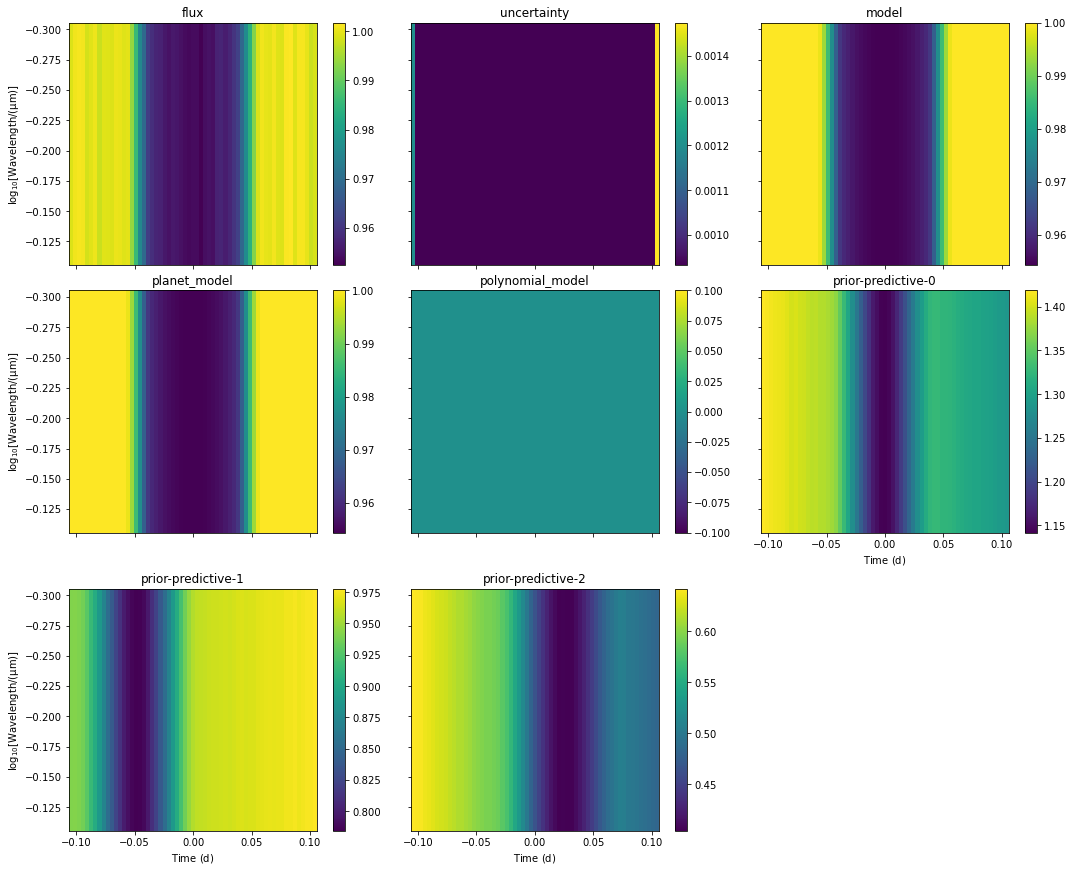

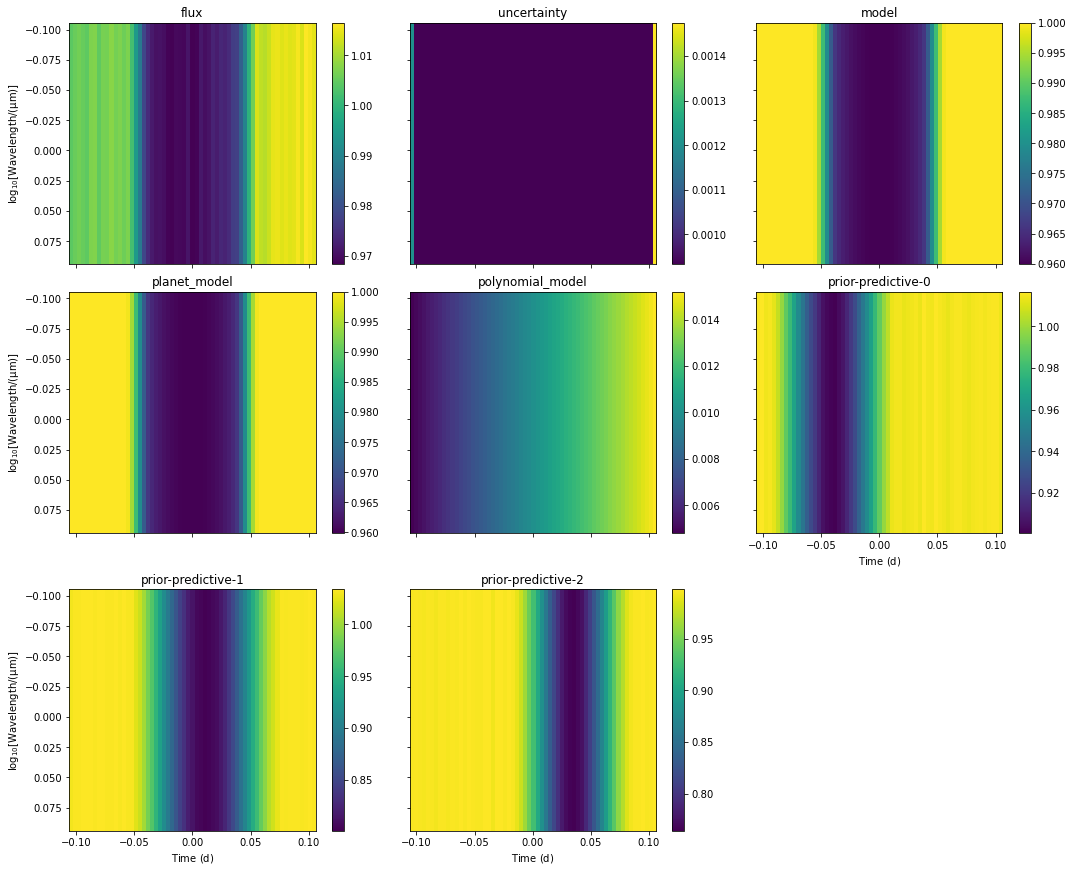

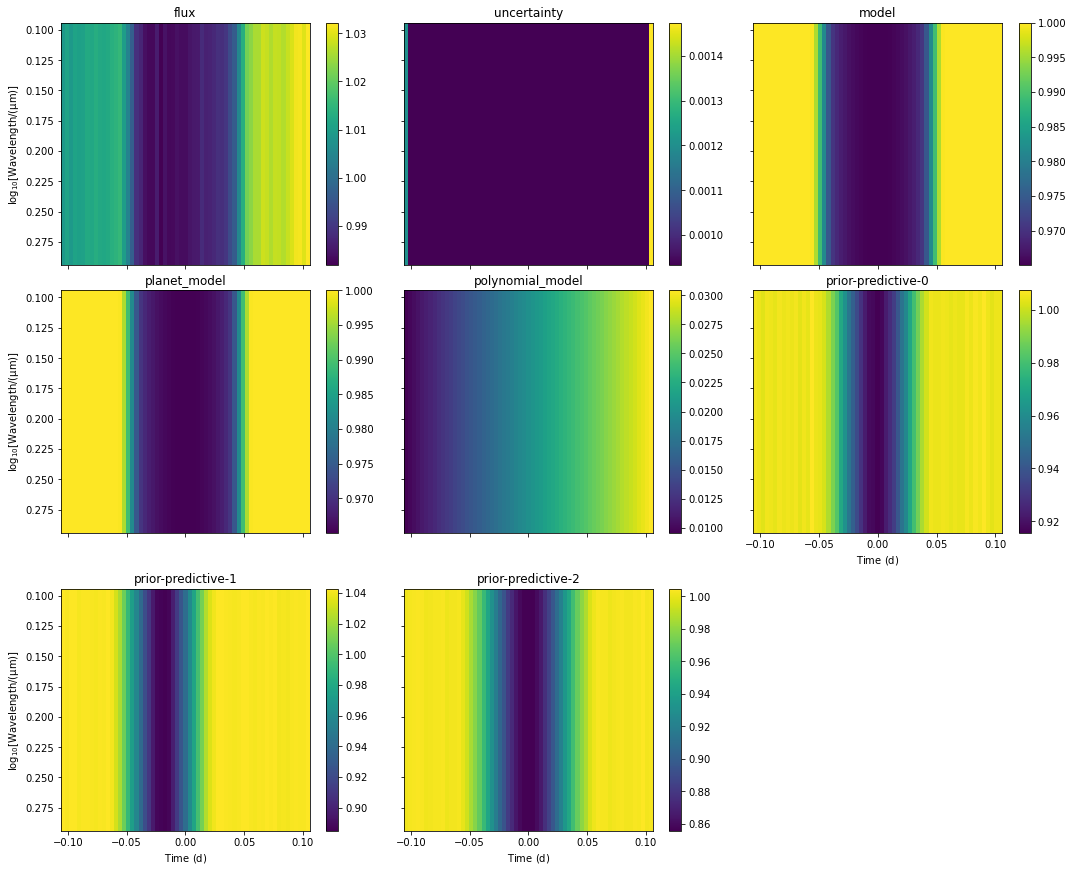

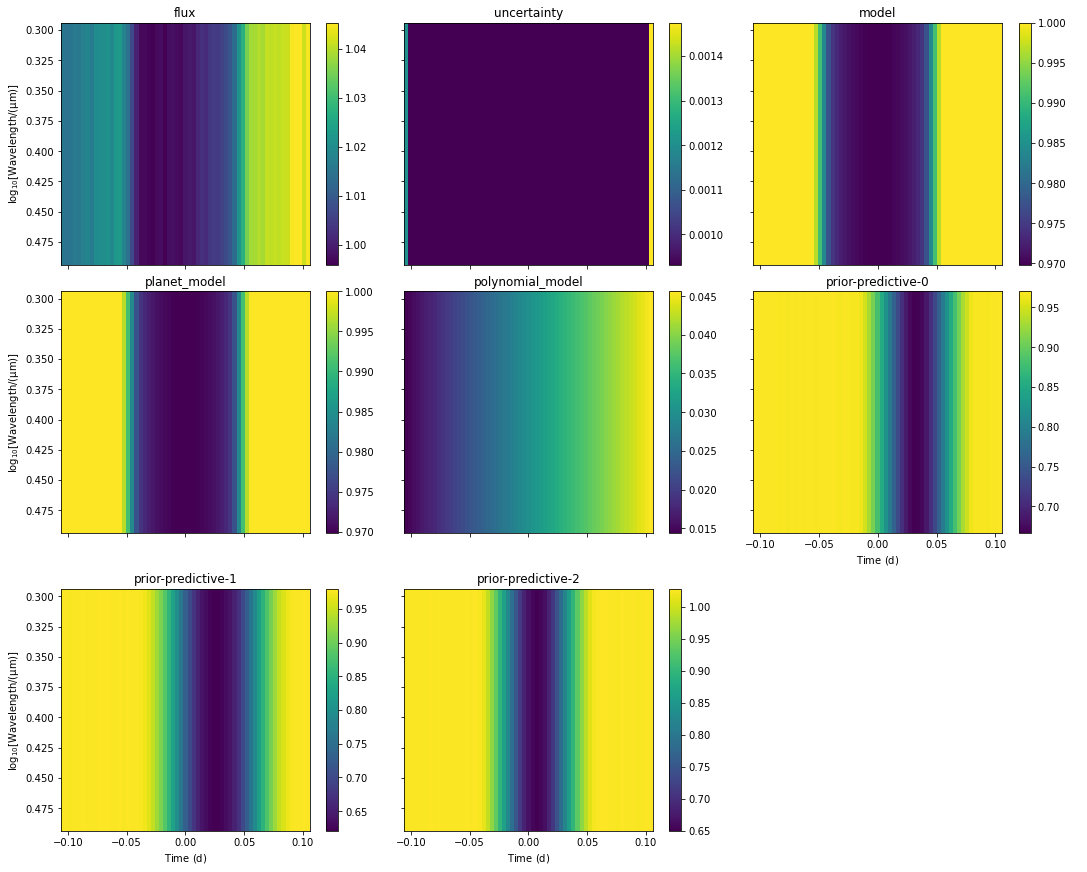

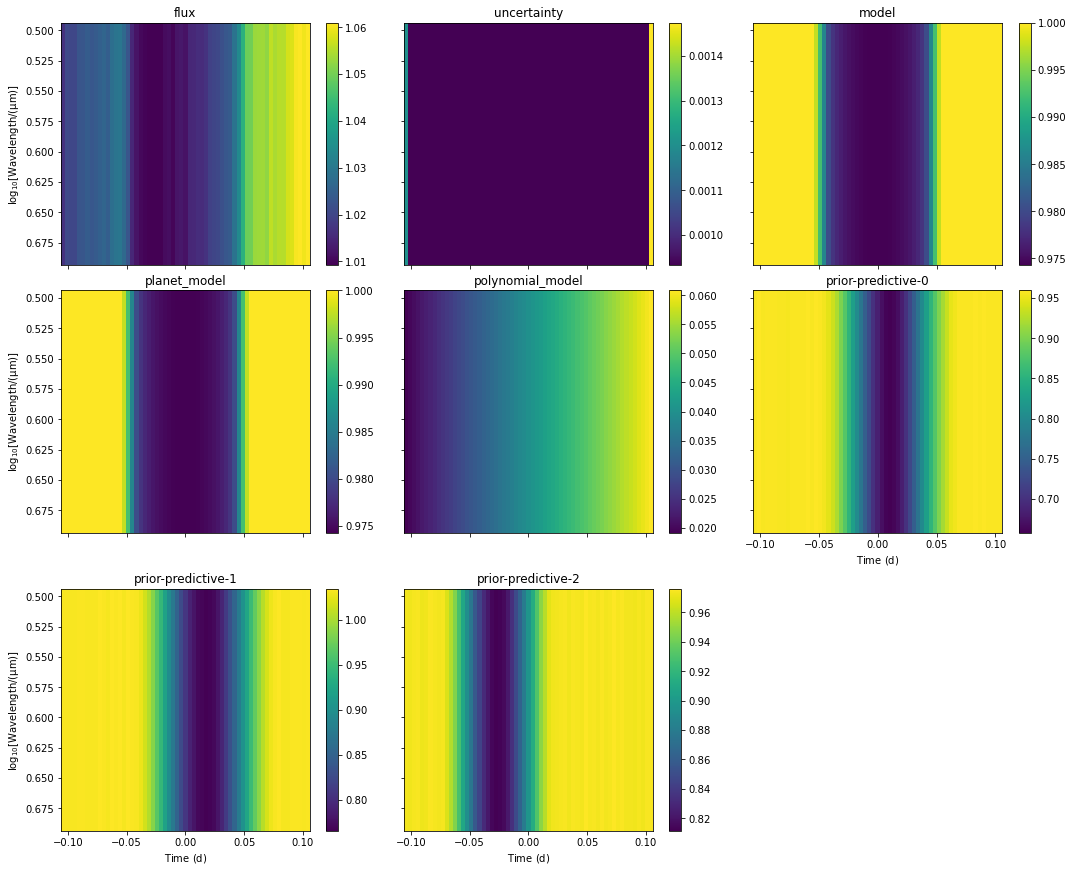

In [6]:
cm.plot_priors()

In [14]:
cm.pymc3_models['transit'].pymc3_model[1]

In [7]:
# from pymc3_ext import sample
# cm.sample(tune=8000, draws=8000, cores=12, chains=4)
# with cm.pymc3_model:
#     opt = optimize(start=t.model.test_point)
for m in cm.pymc3_model
cm.sample()
cm.summarize(round_to=7, fmt='wide')

ValueError: No free random variables to sample.

In [9]:
cm.summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
radius_ratio_w0,0.177202,0.001030,0.174943,0.178783,0.000383,0.000283,9.379301,19.635778,1.342696
epoch,-0.000054,0.000078,-0.000197,0.000096,0.000002,0.000001,2370.252497,2441.368975,1.001522
impact_parameter,0.041695,0.034793,0.000002,0.107531,0.004661,0.003313,29.236812,48.690624,1.094770
stellar_radius,1.176222,0.013065,1.155225,1.199419,0.001148,0.000819,236.271157,1020.515422,1.072648
stellar_mass,0.848362,0.033522,0.800689,0.899671,0.008014,0.005764,15.143217,43.924451,1.185057
limb_darkening[0],0.285607,0.138262,0.000664,0.423210,0.061838,0.046566,7.360285,11.996025,1.512194
limb_darkening[1],0.146800,0.280659,-0.174188,0.750589,0.124656,0.095484,7.586350,18.383963,1.483021
baseline,0.988463,0.023086,0.950388,1.028665,0.004059,0.002896,29.868333,37.442157,1.099356
p_w0[0],0.031404,0.023088,-0.008596,0.069608,0.004062,0.003601,29.766242,36.435162,1.099604
p_w0[1],0.097198,0.000955,0.095496,0.099097,0.000019,0.000014,2439.557802,2389.267700,1.002039



🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

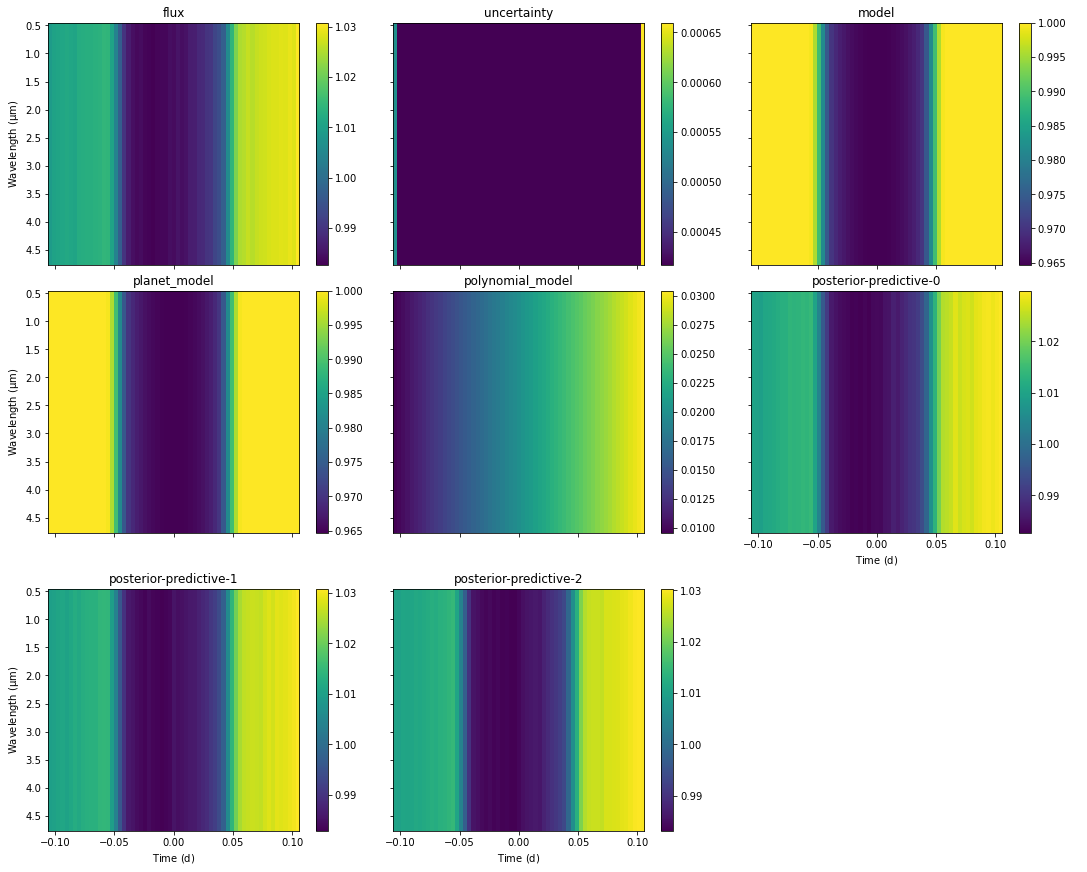

In [10]:
cm.plot_posteriors(cm.trace)

In [11]:
cm_copy = cm


🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars

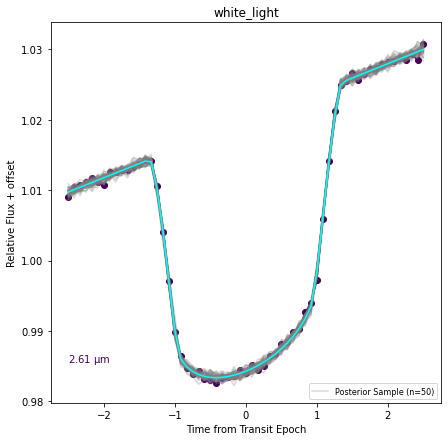

In [12]:
fig, ax = plt.subplots(figsize=(7,7))
from matplotlib.pyplot import cm as cmap

data = cm.get_data()
data.plot()

color=cmap.viridis(np.linspace(0,1,data.nwave))

posterior_predictive_trace = cm.sample_posterior(cm.trace, ndraws=50)
posterior_means = cm.summary['mean']

spacing = 3 * np.nanstd(data.flux)
# spacing = ax._most_recent_chromatic_plot_spacing
for i, w in enumerate(data.wavelength):
    firstplot = True
    transit_params = cm.pymc3_models['transit'].extract_mean_posteriors(cm.summary,i)
    poly_params = cm.pymc3_models['polynomial'].extract_mean_posteriors(cm.summary,i)
    
    poly = cm.pymc3_models['polynomial'].polynomial_model(poly_params)
    transit = cm.pymc3_models['transit'].transit_model(transit_params)
    
    for j in range(50):
        if firstplot:
            plt.plot(data.time, (-spacing*i) + posterior_predictive_trace[f'wavelength_{i}_data'][j],color='gray',alpha=0.3,label='Posterior Sample (n=50)')
            firstplot=False
        else:
            plt.plot(data.time, (-spacing*i) + posterior_predictive_trace[f'wavelength_{i}_data'][j],color='gray',alpha=0.3)
   
    plt.plot(data.time,(transit + poly) + (-spacing*i),color='cyan')
    
plt.title(cm.optimization)
plt.ylabel("Relative Flux + offset")
plt.xlabel("Time from Transit Epoch")
plt.legend(loc='lower right',fontsize=8)
plt.show()
plt.close()
    

In [35]:
poly

array([0.01917522, 0.01986416, 0.0205531 , 0.02124204, 0.02193098,
       0.02261992, 0.02330886, 0.0239978 , 0.02468674, 0.02537568,
       0.02606462, 0.02675355, 0.02744249, 0.02813143, 0.02882037,
       0.02950931, 0.03019825, 0.03088719, 0.03157613, 0.03226507,
       0.03295401, 0.03364295, 0.03433189, 0.03502083, 0.03570976,
       0.0363987 , 0.03708764, 0.03777658, 0.03846552, 0.03915446,
       0.0398434 , 0.04053234, 0.04122128, 0.04191022, 0.04259916,
       0.0432881 , 0.04397704, 0.04466597, 0.04535491, 0.04604385,
       0.04673279, 0.04742173, 0.04811067, 0.04879961, 0.04948855,
       0.05017749, 0.05086643, 0.05155537, 0.05224431, 0.05293325,
       0.05362218, 0.05431112, 0.05500006, 0.055689  , 0.05637794,
       0.05706688, 0.05775582, 0.05844476, 0.0591337 , 0.05982264,
       0.06051158])

# Transit Model

In [ ]:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=4.055259,
                   epoch=Fitted(Uniform,lower=59782.95,upper=59783.05),
                   stellar_radius = Fitted(Uniform, lower=0.1, upper=2.0,testval=0.895),
                   stellar_mass =Fitted(Uniform, lower=0.1, upper=2.0,testval=0.93),
                   radius_ratio=WavelikeFitted(Normal, mu=0.15, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(QuadLimbDark,testval=[0.05,0.35]),
                   baseline=WavelikeFitted(Normal,mu=1.0,sigma=0.0025))
t.summarize_parameters()

In [ ]:
t.setup_orbit()
t.attach_data(rn)
t.plot_orbit()
t.setup_lightcurves()
t.setup_likelihood()

In [ ]:
prior_predictive_trace = t.sample_prior(ndraws=3)
for i in range(3):
    flux_for_this_sample = np.array([prior_predictive_trace[f'wavelength_{w}_data'][i] for w in range(rn.nwave)])
    rn.fluxlike[f'prior-predictive-{i}'] = flux_for_this_sample
rn.imshow_quantities()

In [ ]:
vars_to_opt = [t.model[f"radius_ratio_w{w}"] for w in range(rn.nwave)]
print(vars_to_opt)

with t.model:
    opt = optimize(start=t.model.test_point)
    opt = optimize(start=opt, vars=vars_to_opt)
    trace = sample(start=opt,tune=8000, draws=8000, cores=12, chains=4)

In [ ]:
posterior_predictive_trace = t.sample_posterior(trace,ndraws=50)

In [ ]:
with t.model:
    summary = az.summary(trace, round_to=7, fmt='wide')
    print(summary)

In [ ]:
model_staticld, planet_params, wavelength,transmission = import_patricio_model()

plt.figure(figsize=(7,4))
plt.plot(wavelength,transmission*100,color='cyan',alpha=0.5,label='Spectrum Model')
for w in range(rn.nwave):
    rr = (summary['mean'][f"radius_ratio_w{w}"]**2)*100
    hdi3 = (summary['hdi_3%'][f"radius_ratio_w{w}"]**2)*100
    hdi97 = (summary['hdi_97%'][f"radius_ratio_w{w}"]**2)*100
    plt.plot(rn.wavelength[w],rr,'k.',markersize=6)
    plt.errorbar(rn.wavelength[w],rr, xerr=0.05*u.micron,
                 yerr=np.array([np.abs(hdi3-rr),np.abs(hdi97-rr)]).reshape((2,1)),c='k',alpha=0.5,capsize=3)

plt.ylabel("Transit Depth [%]")
plt.xlabel("Wavelength [microns]")
plt.xlim(2,4.5)
plt.legend()
plt.show()

In [ ]:
planet_params

In [ ]:
fig, ax = plt.subplots(figsize=(7,10))
from matplotlib.pyplot import cm
color=cm.viridis(np.linspace(0,1,rn.nwave))
firstplot = True
offset = 0
for w in range(rn.nwave):
    for i in range(50):
        if firstplot:
            plt.plot(rn.time, offset + posterior_predictive_trace[f'wavelength_{w}_data'][i],color='gray',alpha=0.5,label='Posterior Sample\n (n=50)')
            firstplot=False
        else:
            plt.plot(rn.time, offset + posterior_predictive_trace[f'wavelength_{w}_data'][i],color='gray',alpha=0.5)
    plt.plot(rn.time, offset + rn.flux[w],linestyle="None", markersize=8, marker='.', color=color[w],label="%.1f microns"%rn.wavelength[w].to_value())
    offset = offset-0.04
plt.ylabel("Relative Flux + offset")
plt.xlabel("Time from Transit Epoch")
plt.legend(loc='upper right',fontsize=8)